In [1]:
import os
from dataclasses import dataclass
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import warnings

from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

pd.set_option("display.width", 100)
pd.set_option("display.max_columns", 70)
warnings.filterwarnings("ignore")

In [2]:
@dataclass
class Config:
	#device: torch.device = torch.device("mps")
	data_dir: os.PathLike = "./data/"
	n_folds: int = 4 #10
	seed: int = 43098

def RMSE(y_pred, true_value):
	"""Computes the root mean squared error."""
	return np.sqrt(mean_squared_error(y_pred, true_value))

In [3]:
train_df = pd.read_csv(os.path.join(Config.data_dir, "Train.csv"))
test_df = pd.read_csv(os.path.join(Config.data_dir, "Test.csv"))
print(f"Train shape: {train_df.shape}\nTest shape: {test_df.shape}")
train_df.head()

Train shape: (3870, 44)
Test shape: (1290, 43)


,ID,District,Block,CultLand,CropCultLand,LandPreparationMethod,CropTillageDate,CropTillageDepth,CropEstMethod,RcNursEstDate,SeedingSowingTransplanting,SeedlingsPerPit,NursDetFactor,TransDetFactor,TransplantingIrrigationHours,TransplantingIrrigationSource,TransplantingIrrigationPowerSource,TransIrriCost,StandingWater,OrgFertilizers,Ganaura,CropOrgFYM,PCropSolidOrgFertAppMethod,NoFertilizerAppln,CropbasalFerts,BasalDAP,BasalUrea,MineralFertAppMethod,FirstTopDressFert,1tdUrea,1appDaysUrea,2tdUrea,2appDaysUrea,MineralFertAppMethod.1,Harv_method,Harv_date,Harv_hand_rent,Threshing_date,Threshing_method,Residue_length,Residue_perc,Stubble_use,Acre,Yield
0,ID_GTFAC7PEVWQ9,Nalanda,Noorsarai,45,40,TractorPlough FourWheelTracRotavator,2022-07-20,5,Manual_PuddledRandom,2022-06-27,2022-07-21,2.0,CalendarDate IrrigWaterAvailability SeedAvaila...,CalendarDate SeedlingAge RainArrival IrrigWate...,5.0,Boring,Electric,200.0,2.0,NaN,NaN,NaN,NaN,2,Urea,NaN,20.0,Broadcasting,Urea,15.0,18.0,NaN,NaN,Broadcasting,machine,2022-11-16,NaN,2022-11-16,machine,30,40,plowed_in_soil,0.312500,600
1,ID_TK40ARLSPOKS,Nalanda,Rajgir,26,26,WetTillagePuddling TractorPlough FourWheelTrac...,2022-07-18,5,Manual_PuddledRandom,2022-06-20,2022-07-20,2.0,CalendarDate PreMonsoonShowers IrrigWaterAvail...,CalendarDate SeedlingAge RainArrival IrrigWate...,5.0,Boring,Electric,125.0,3.0,NaN,NaN,NaN,NaN,2,DAP Urea,15.0,10.0,Broadcasting,Urea,20.0,39.0,NaN,NaN,Broadcasting,hand,2022-11-25,3.0,2022-12-24,machine,24,10,plowed_in_soil,0.312500,600
2,ID_1FJY2CRIMLZZ,Gaya,Gurua,10,10,TractorPlough FourWheelTracRotavator,2022-06-30,6,Manual_PuddledRandom,2022-06-20,2022-08-13,2.0,PreMonsoonShowers IrrigWaterAvailability Labou...,SeedlingAge IrrigWaterAvailability LaborAvaila...,4.0,Boring,Electric,80.0,2.0,Ganaura FYM,1.0,1.0,SoilApplied,2,DAP,4.0,NaN,SoilApplied,Urea,5.0,65.0,NaN,NaN,RootApplication,hand,2022-12-12,480.0,2023-01-11,machine,30,10,plowed_in_soil,0.148148,225
3,ID_I3IPXS4DB7NE,Gaya,Gurua,15,15,TractorPlough FourWheelTracRotavator,2022-06-16,6,Manual_PuddledRandom,2022-06-17,2022-07-17,2.0,CalendarDate PreMonsoonShowers IrrigWaterAvail...,CalendarDate SeedlingAge RainArrival IrrigWate...,NaN,NaN,NaN,NaN,NaN,Ganaura,1.0,NaN,SoilApplied,2,DAP Urea,6.0,3.0,Broadcasting,Urea,5.0,5.0,NaN,NaN,Broadcasting,hand,2022-12-02,240.0,2022-12-29,hand,26,10,plowed_in_soil,0.222222,468
4,ID_4T8YQWXWHB4A,Nalanda,Noorsarai,60,60,TractorPlough WetTillagePuddling,2022-07-19,4,Manual_PuddledRandom,2022-06-21,2022-07-20,2.0,CalendarDate IrrigWaterAvailability SeedAvaila...,SeedlingAge RainArrival IrrigWaterAvailability...,9.0,Boring,Electric,300.0,2.0,NaN,NaN,NaN,NaN,2,Urea DAP,15.0,30.0,Broadcasting,Urea,30.0,26.0,NaN,NaN,Broadcasting,machine,2022-11-30,NaN,2022-12-02,machine,24,40,plowed_in_soil,0.468750,550


<Axes: >

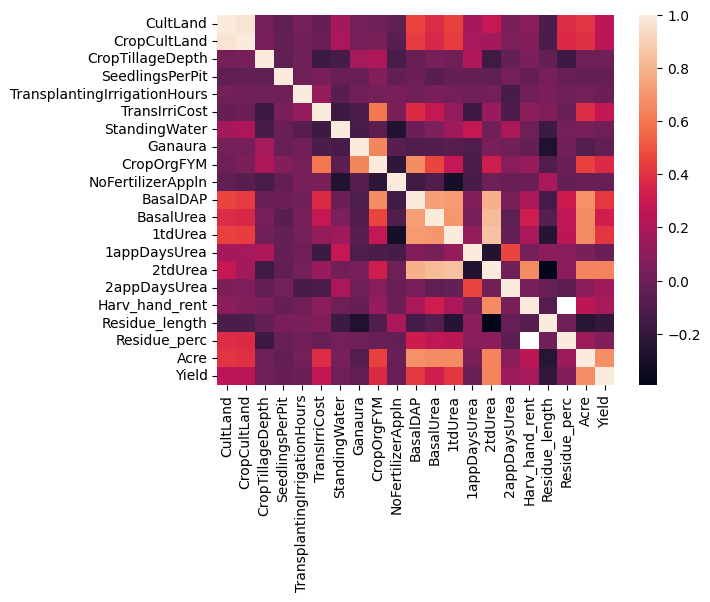

In [4]:
#train_df.dtype
correlations = train_df.select_dtypes(include=[float, int]).corr()
sns.heatmap(correlations)

In [5]:
train_df.describe()

,CultLand,CropCultLand,CropTillageDepth,SeedlingsPerPit,TransplantingIrrigationHours,TransIrriCost,StandingWater,Ganaura,CropOrgFYM,NoFertilizerAppln,BasalDAP,BasalUrea,1tdUrea,1appDaysUrea,2tdUrea,2appDaysUrea,Harv_hand_rent,Residue_length,Residue_perc,Acre,Yield
count,3870.000000,3870.000000,3870.000000,3581.000000,3677.000000,2988.000000,3632.000000,1453.000000,1196.000000,3870.000000,3327.000000,2166.000000,3314.000000,3314.000000,1176.000000,1170.000000,3618.000000,3870.000000,3870.000000,3870.000000,3870.000000
mean,28.527907,24.727132,4.488372,2.706507,8.017677,379.726908,3.247522,29.731590,57.445652,2.184496,11.452359,13.351801,11.513881,29.200362,7.375000,58.764957,536.622443,26.517829,11.767442,0.292826,594.269251
std,30.454218,27.994802,1.133044,7.624397,42.612470,419.724782,2.207276,122.680882,328.251615,0.634632,8.422049,9.701597,8.715856,12.139109,5.932502,11.356588,1138.613827,3.192873,7.064864,0.206918,651.916953
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,10.000000,0.045455,4.000000
25%,12.000000,10.000000,4.000000,2.000000,2.000000,150.000000,2.000000,1.000000,1.000000,2.000000,6.000000,7.000000,6.000000,23.000000,4.000000,58.000000,150.000000,25.000000,10.000000,0.156250,300.000000
50%,20.000000,20.000000,4.000000,2.000000,4.000000,250.000000,3.000000,3.000000,2.000000,2.000000,10.000000,10.000000,10.000000,28.000000,6.000000,60.000000,400.000000,26.000000,10.000000,0.227273,425.000000
75%,35.000000,30.000000,5.000000,3.000000,6.000000,450.000000,4.000000,4.000000,5.000000,3.000000,15.000000,16.000000,15.000000,36.000000,10.000000,65.000000,700.000000,30.000000,10.000000,0.370370,740.000000
max,800.000000,800.000000,8.000000,442.000000,2000.000000,6000.000000,15.000000,1400.000000,4000.000000,4.000000,100.000000,90.000000,90.000000,332.000000,67.000000,97.000000,60000.000000,30.000000,40.000000,2.187500,16800.000000


Mean yield: 594.2692506459948	 Min: 4 	Max: 16800
Standard Deviation of yield: 651.8327208567715


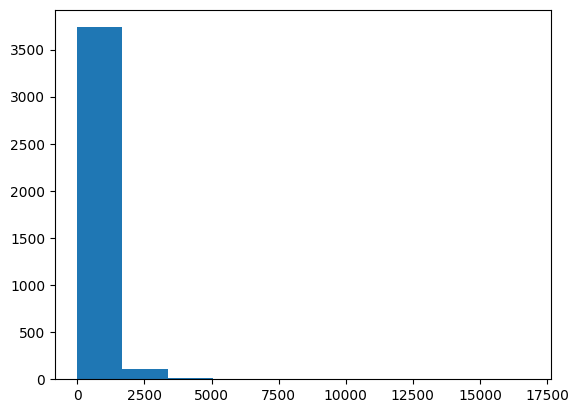

In [6]:
## yield distribution over entire dataset
print(f"Mean yield: {np.mean(train_df['Yield'].values)}\t Min: {np.min(train_df['Yield'].values)} \tMax: {np.max(train_df['Yield'].values)}")
print(f"Standard Deviation of yield: {np.std(train_df['Yield'].values)}")
plt.hist(train_df["Yield"]);

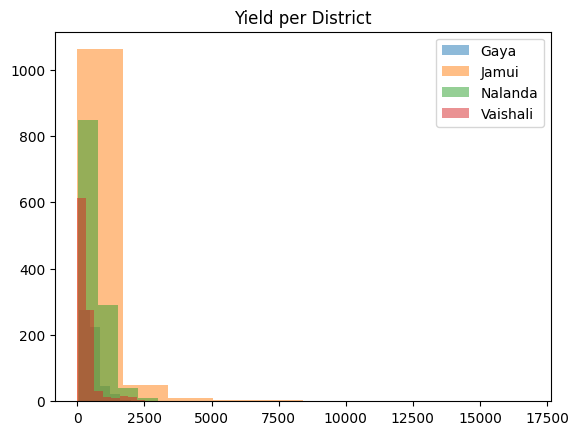

In [7]:
groups = train_df.groupby("District")["Yield"]
for g_name, group_count in groups:
	plt.title("Yield per District")
	plt.hist(group_count, alpha=0.5, density=False, label=g_name)
plt.legend()
plt.show()

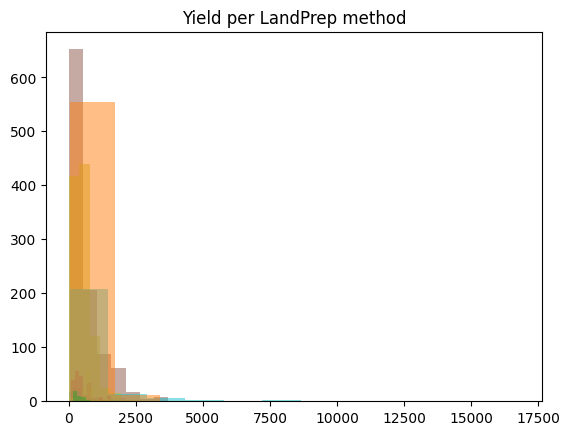

In [8]:
landprep_groups = train_df.groupby("LandPreparationMethod")["Yield"]
for g_name, group_count in landprep_groups:
	plt.title("Yield per LandPrep method")
	plt.hist(group_count, alpha=0.5, density=False, label=g_name)
#plt.legend()
plt.show()

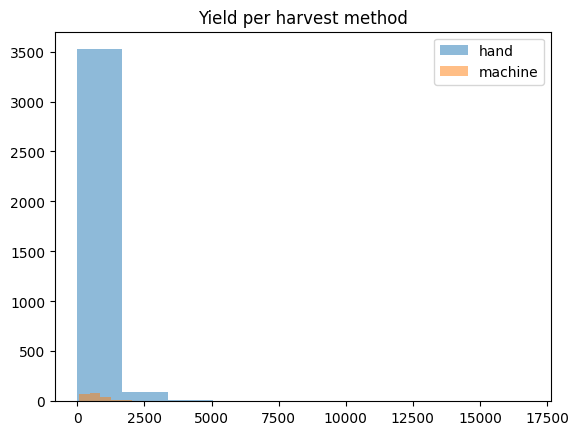

In [9]:
harv_method_groups = train_df.groupby("Harv_method")["Yield"]
for g_name, group_count in harv_method_groups:
	plt.title("Yield per harvest method")
	plt.hist(group_count, alpha=0.5, density=False, label=g_name)
plt.legend()
plt.show()

In [10]:
train_df["District"].value_counts(), test_df["District"].value_counts()

(District
 Nalanda     1193
 Jamui       1127
 Vaishali     980
 Gaya         570
 Name: count, dtype: int64,
 District
 Nalanda     404
 Jamui       384
 Vaishali    325
 Gaya        177
 Name: count, dtype: int64)

In [11]:
train_df["Block"].value_counts(), test_df["Block"].value_counts()

(Block
 Rajgir        850
 Jamui         626
 Mahua         607
 Khaira        500
 Gurua         358
 Noorsarai     343
 Chehrakala    239
 Wazirganj     213
 Garoul        134
 Name: count, dtype: int64,
 Block
 Rajgir        271
 Jamui         214
 Mahua         206
 Khaira        169
 Noorsarai     133
 Gurua         111
 Chehrakala     73
 Wazirganj      66
 Garoul         46
 Lohra           1
 Name: count, dtype: int64)

In [12]:
# LandPreparation methods
print(f"Train num unique LandPrep methods: {train_df['LandPreparationMethod'].nunique()}")
print(f"Test num unique LandPrep methods: {test_df['LandPreparationMethod'].nunique()}")
train_lp_complement = set((list(train_df["LandPreparationMethod"].unique()))).difference(set(list(test_df["LandPreparationMethod"].unique())))
len(train_lp_complement), train_lp_complement

Train num unique LandPrep methods: 43
Test num unique LandPrep methods: 30


(14,
 {'BullockPlough',
  'BullockPlough TractorPlough WetTillagePuddling',
  'BullockPlough TractorPlough WetTillagePuddling FourWheelTracRotavator',
  'BullockPlough WetTillagePuddling',
  'FourWheelTracRotavator BullockPlough',
  'FourWheelTracRotavator BullockPlough WetTillagePuddling TractorPlough',
  'FourWheelTracRotavator WetTillagePuddling',
  'FourWheelTracRotavator WetTillagePuddling BullockPlough TractorPlough',
  'FourWheelTracRotavator WetTillagePuddling TractorPlough',
  'TractorPlough FourWheelTracRotavator BullockPlough',
  'TractorPlough FourWheelTracRotavator BullockPlough WetTillagePuddling',
  'TractorPlough FourWheelTracRotavator WetTillagePuddling BullockPlough',
  'TractorPlough Other',
  'TractorPlough WetTillagePuddling BullockPlough FourWheelTracRotavator'})

The train and test data are collected over the same districts and blocks except for 1 outlier block, `Lohra` in the test set that has no data in the train set. <br/>
The `Yield` feature contains outliers.<br/>
There's a huge variation between the `crop yield` and the different land preparation methods.


In [13]:
# drop Block since there's a block in test not present in train
# RcNursEstDate: date_of_nursery_establishment,
# MineralFertAppMethod, FirstTopDressFert: some categories in test but not train so drop initially
#drop_columns = ["Block", "RcNursEstDate", "NursDetFactor", "TransDetFactor", "MineralFertAppMethod", "FirstTopDressFert"]


## labelencode/one-hot columns
## CropEstMethod: crop transplanting method
## PCropSolidOrgFertAppMethod: Method of applying organic fertilizer in your previous crop during land preparation
## CropbasalFerts- type of chemical fert applied during landprep
## MineralFertAppMethod- method of applying chemical fert for landprep
## FirstTopDressFert: type of chemical fert applied in 2nd dose (land prep)
## MineralFertAppMethod.1: method of applying chemical fert to crops during 2nd dose
## Harv_method: harvest method
## Stubble_use: method of management of the stubble afer harvesting

In [14]:
#train_df["CropbasalFerts"].nunique(), test_df["CropbasalFerts"].nunique()
#train_df["Stubble_use"].value_counts(), test_df["Stubble_use"].value_counts()

# create seasons, crop_gestation_period features
# NursDetFactor, TransDetFactor : reason for choosing nursery date, transplanting date respectively
# Threshing_date: threshing date for harvested crops
time_columns = ["CropTillageDate", "SeedingSowingTransplanting", "Harv_date", "Threshing_date"]

for col in time_columns:
	train_df[col] = pd.to_datetime(train_df[col])
	test_df[col] = pd.to_datetime(test_df[col])

train_df["gestation"] = (train_df["Harv_date"] - train_df["SeedingSowingTransplanting"]).dt.days
test_df["gestation"] = (test_df["Harv_date"] - test_df["SeedingSowingTransplanting"]).dt.days

train_df["till_year"] = train_df["CropTillageDate"].dt.year
train_df["till_month"] = train_df["CropTillageDate"].dt.month
train_df["trplant_year"] = train_df["SeedingSowingTransplanting"].dt.year
train_df["trplant_month"] = train_df["SeedingSowingTransplanting"].dt.month
train_df["harvest_year"] = train_df["Harv_date"].dt.year
train_df["harvest_month"] = train_df["Harv_date"].dt.month
train_df["thresh_year"] = train_df["Threshing_date"].dt.year
train_df["thresh_month"] = train_df["Threshing_date"].dt.month

test_df["till_year"] = test_df["CropTillageDate"].dt.year
test_df["till_month"] = test_df["CropTillageDate"].dt.month
test_df["trplant_year"] = test_df["SeedingSowingTransplanting"].dt.year
test_df["trplant_month"] = test_df["SeedingSowingTransplanting"].dt.month
test_df["harvest_year"] = test_df["Harv_date"].dt.year
test_df["harvest_month"] = test_df["Harv_date"].dt.month
test_df["thresh_year"] = test_df["Threshing_date"].dt.year
test_df["thresh_month"] = test_df["Threshing_date"].dt.month

get_seasons_columns = {"trplant": "trplant_month", "harvest": "harvest_month"}
for k, v in get_seasons_columns.items():
	train_df.loc[train_df[v] < 4, f"{k}_season"] = "rabi" # winter
	train_df.loc[(train_df[v] >= 4) & (train_df[v] < 7), f"{k}_season"] = "zaid" # summer-crops; fruits, vegetables (apr-jun)
	train_df.loc[(train_df[v]) >= 7 & (train_df[v] < 11), f"{k}_season"] = "kharif" #southwest monsoon; maize, millet,rice,etc
	train_df.loc[(train_df[v] >= 11) & (train_df[v] <= 12), f"{k}_season"] = "rabi" # winter; wheat,tobacco

	test_df.loc[test_df[v] < 4, f"{k}_season"] = "rabi" # winter: Nov-Mar
	test_df.loc[(test_df[v] >= 4) & (test_df[v] < 7), f"{k}_season"] = "zaid" # (apr-jun)
	test_df.loc[(test_df[v]) >= 7 & (test_df[v] < 11), f"{k}_season"] = "kharif" # July-Oct
	test_df.loc[(test_df[v] >= 11) & (test_df[v] <= 12), f"{k}_season"] = "rabi" # Nov-Mar

In [15]:
#tr = list(train_df["harvest_season"].unique())
#ts = list(test_df["harvest_season"].unique())
#out = []
#for i in ts:
#	if i not in tr:
#		out.append(i)
#out

## Train and test data contains only two months, July & August, the Kharif season across different years for transplanting.
## while harvesting is carried out from September through March; Most harvesting is done in Oct, Nov. & Dec

In [16]:
train_df["harvest_month"].value_counts(), test_df["harvest_month"].value_counts()

(harvest_month
 11    2493
 10     807
 12     554
 1        8
 9        5
 3        2
 2        1
 Name: count, dtype: int64,
 harvest_month
 11    828
 10    254
 12    202
 9       5
 8       1
 Name: count, dtype: int64)

In [17]:
def label_encode(columns: list, train_df: pd.DataFrame, test_df: pd.DataFrame):
	"""Label encode given categorical columns."""
	train_data = train_df.copy()
	test_data = test_df.copy()

	for col in columns:
		col_encoder = LabelEncoder()
		train_data[col] = col_encoder.fit_transform(train_data[col])
		test_data[col] = col_encoder.transform(test_data[col])

	return train_data, test_data

lb_encode_columns = [
	"District", "TransplantingIrrigationSource", "TransplantingIrrigationPowerSource"
] #"PCropSolidOrgFertAppMethod",
onehot_encode_columns = [
	"CropEstMethod","trplant_season", "harvest_season", "Harv_method", "Threshing_method",
] # "trplant_season", #"MineralFertAppMethod.1", "Stubble_use",
drop_columns = ["Block", "RcNursEstDate", "NursDetFactor", "CropbasalFerts", "Residue_length", "Residue_perc", "CropCultLand",#"harvest_month",
"OrgFertilizers", "TransDetFactor", "MineralFertAppMethod", "FirstTopDressFert", "LandPreparationMethod", "MineralFertAppMethod.1",
"Stubble_use", "PCropSolidOrgFertAppMethod", "trplant_month", "till_month", "TransIrriCost", "1tdUrea", "1appDaysUrea", "2tdUrea", "2appDaysUrea"
] #"BasalDAP", "BasalUrea"
drop_columns += time_columns

#["CultLand", "gestation", "Acre"]

train_df = train_df.drop(drop_columns, axis=1)
test_df = test_df.drop(drop_columns, axis=1)
train_df, test_df = label_encode(lb_encode_columns, train_df, test_df)
train_df = pd.get_dummies(train_df, columns=onehot_encode_columns)
test_df = pd.get_dummies(test_df, columns=onehot_encode_columns)
print(f"Train shape: {train_df.shape},  Test shape: {test_df.shape}")
train_df.head(3)


Train shape: (3870, 35),  Test shape: (1290, 34)


,ID,District,CultLand,CropTillageDepth,SeedlingsPerPit,TransplantingIrrigationHours,TransplantingIrrigationSource,TransplantingIrrigationPowerSource,StandingWater,Ganaura,CropOrgFYM,NoFertilizerAppln,BasalDAP,BasalUrea,Harv_hand_rent,Acre,Yield,gestation,till_year,trplant_year,harvest_year,harvest_month,thresh_year,thresh_month,CropEstMethod_Broadcasting,CropEstMethod_LineSowingAfterTillage,CropEstMethod_Manual_PuddledLine,CropEstMethod_Manual_PuddledRandom,trplant_season_kharif,harvest_season_kharif,harvest_season_rabi,Harv_method_hand,Harv_method_machine,Threshing_method_hand,Threshing_method_machine
0,ID_GTFAC7PEVWQ9,2,45,5,2.0,5.0,0,1,2.0,NaN,NaN,2,NaN,20.0,NaN,0.312500,600,118,2022,2022,2022,11,2022,11,False,False,False,True,True,False,True,False,True,False,True
1,ID_TK40ARLSPOKS,2,26,5,2.0,5.0,0,1,3.0,NaN,NaN,2,15.0,10.0,3.0,0.312500,600,128,2022,2022,2022,11,2022,12,False,False,False,True,True,False,True,True,False,False,True
2,ID_1FJY2CRIMLZZ,0,10,6,2.0,4.0,0,1,2.0,1.0,1.0,2,4.0,NaN,480.0,0.148148,225,121,2022,2022,2022,12,2023,1,False,False,False,True,True,False,True,True,False,False,True


In [18]:
# drop outliers
train_df = train_df.drop(train_df[train_df["Yield"] > 10000].index).reset_index(drop=True)

In [19]:
## create folds
#skfold = StratifiedKFold(n_splits=Config.n_folds, shuffle=True, random_state=Config.seed)
skfold = StratifiedGroupKFold(n_splits=Config.n_folds)
groups = train_df["District"]
for i, (train_idx, val_idx) in enumerate(skfold.split(train_df, train_df["Yield"], groups), 1):
	train_df.loc[val_idx, "fold"] = int(i)
train_df.head()

,ID,District,CultLand,CropTillageDepth,SeedlingsPerPit,TransplantingIrrigationHours,TransplantingIrrigationSource,TransplantingIrrigationPowerSource,StandingWater,Ganaura,CropOrgFYM,NoFertilizerAppln,BasalDAP,BasalUrea,Harv_hand_rent,Acre,Yield,gestation,till_year,trplant_year,harvest_year,harvest_month,thresh_year,thresh_month,CropEstMethod_Broadcasting,CropEstMethod_LineSowingAfterTillage,CropEstMethod_Manual_PuddledLine,CropEstMethod_Manual_PuddledRandom,trplant_season_kharif,harvest_season_kharif,harvest_season_rabi,Harv_method_hand,Harv_method_machine,Threshing_method_hand,Threshing_method_machine,fold
0,ID_GTFAC7PEVWQ9,2,45,5,2.0,5.0,0,1,2.0,NaN,NaN,2,NaN,20.0,NaN,0.312500,600,118,2022,2022,2022,11,2022,11,False,False,False,True,True,False,True,False,True,False,True,3.0
1,ID_TK40ARLSPOKS,2,26,5,2.0,5.0,0,1,3.0,NaN,NaN,2,15.0,10.0,3.0,0.312500,600,128,2022,2022,2022,11,2022,12,False,False,False,True,True,False,True,True,False,False,True,3.0
2,ID_1FJY2CRIMLZZ,0,10,6,2.0,4.0,0,1,2.0,1.0,1.0,2,4.0,NaN,480.0,0.148148,225,121,2022,2022,2022,12,2023,1,False,False,False,True,True,False,True,True,False,False,True,4.0
3,ID_I3IPXS4DB7NE,0,15,6,2.0,NaN,6,3,NaN,1.0,NaN,2,6.0,3.0,240.0,0.222222,468,138,2022,2022,2022,12,2022,12,False,False,False,True,True,False,True,True,False,True,False,4.0
4,ID_4T8YQWXWHB4A,2,60,4,2.0,9.0,0,1,2.0,NaN,NaN,2,15.0,30.0,NaN,0.468750,550,133,2022,2022,2022,11,2022,12,False,False,False,True,True,False,True,False,True,False,True,3.0


In [20]:
train_df["fold"].value_counts()

fold
3.0    1193
1.0    1125
2.0     980
4.0     570
Name: count, dtype: int64

In [21]:
train_df = train_df.drop(["ID"], axis = 1)
train_df = train_df.fillna(train_df.median())

test_df = test_df.drop(["ID"], axis=1)
test_df = test_df.fillna(test_df.median())

In [22]:
#np.ceil(train_df.mean())

In [23]:
scores = []
predictions = []

for fold in range(1, Config.n_folds+1):
	print(f"======= Fold {fold}========")
	df_train = train_df[train_df["fold"] != fold]
	df_val = train_df[train_df["fold"] == fold]
	train_target = df_train["Yield"]
	val_target = df_val["Yield"]

	df_train.drop(["fold", "Yield"], axis=1, inplace=True)
	df_val.drop(["fold", "Yield"], axis=1, inplace=True)
	assert df_train.shape[1] == df_val.shape[1], f"Train and Val data Shape Mismatch. Got {df_train.shape} & {df_val.shape}."

	xgb_model = xgb.XGBRegressor(
		n_estimators=350,
		max_depth=5,
		max_leaves=150,
		eval_metric="rmse",
		objective="reg:squarederror",
		colsample_bytree=0.9,
		subsample=0.9,
		reg_alpha=1.5,
		learning_rate=0.143,
		random_state=Config.seed
	)
	
	xgb_model.fit(df_train, train_target)
	val_preds = xgb_model.predict(df_val)
	test_preds = xgb_model.predict(test_df.values)
	score = RMSE(val_target, val_preds)
	scores.append(score)
	print(f"Fold {fold} RMSE: {score}")
	predictions.append(test_preds)

======= Fold 1========
Fold 1 RMSE: 554.3848083427918
======= Fold 2========
Fold 2 RMSE: 349.6391298702207
======= Fold 3========
Fold 3 RMSE: 402.33933020279534
======= Fold 4========
Fold 4 RMSE: 215.24767468410172


In [24]:
np.mean(scores), np.mean([scores[2], scores[3]])

(380.4027357749774, 308.7935024434485)

In [27]:
preds = [predictions[2], predictions[3]] #[predictions[2], predictions[5], predictions[8]]

In [31]:
tdf = pd.read_csv(os.path.join(Config.data_dir, "Test.csv"))
sub_df = pd.DataFrame()
sub_df["ID"] = tdf["ID"]
sub_df["Yield"] = predictions[3] #np.mean(predictions, 0)
sub_df.to_csv("sub_xgb_cat_cols_dropoutliers_>10k_drop_features_district_sgkff4.csv", index=False)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

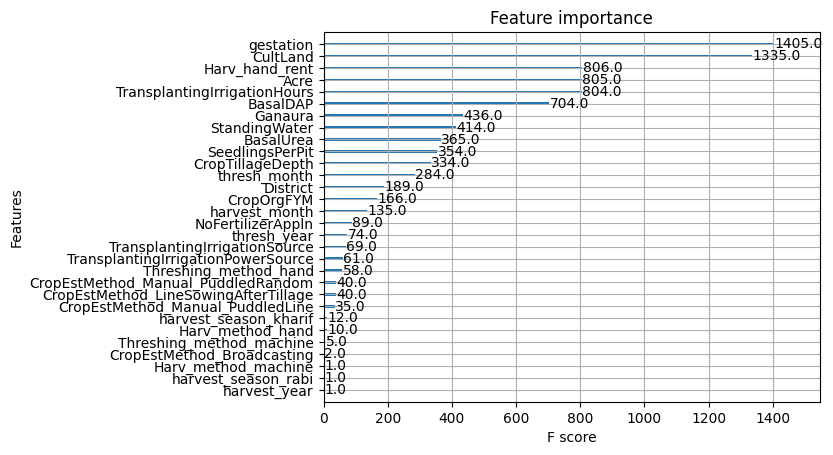

In [26]:
xgb.plot_importance(xgb_model)

In [ ]:
# sub_xgb_baseline_w_categorical_cols: current best
# average over [predictions[2], predictions[3], predictions[7], predictions[8]]
# md:5 xgb, no season col, month/year features

## median imputation performs better with stratified groupkf, while 0 imputation performs better with stratifiedkfold, mean imputation performs poorly